In [1]:
%matplotlib inline
import lightkurve as lk
import matplotlib.pyplot as plt
import scipy
import numpy as np
import astropy.units as u
from lightkurve import search_targetpixelfile

import starry

import pymc3 as pm
import pymc3_ext as pmx
import exoplanet

starry.config.quiet = True
starry.config.lazy = True

lcflist = lk.search_lightcurve('DI Her')
spoc = lcflist[0].download()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


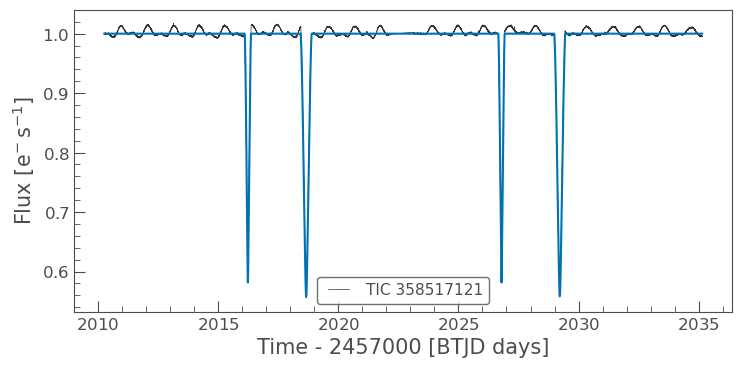

In [2]:
#create spherical star system presented in Gaudi et al. 2017
pri_map = starry.Map(udeg=2, gdeg=4) #ydeg = 2*order_approx udeg=2
pri_map[1] = 0.124
pri_map[2] = 0.262

pri = starry.Primary(pri_map, m=5.1, r=2.4,prot=1.07)
sec_map = starry.Map(udeg=2, gdeg=4)

sec_map[1] = 0.124
sec_map[2] = 0.262
sec_map.amp=0.99
sec = starry.kepler.Secondary(map=sec_map,
    m=4.4,  # mass in solar masses
    r=2.58,  # radius in solar radii
    porb=10.55004,  # orbital period in days
    inc=89.02,
    Omega=70,  # longitude of ascending node in degrees
    ecc=0.505,  # eccentricity
    w=326.6,  # longitude of pericenter in degrees
    t0=2018.6681,  # time of transit in days
)
sys = starry.System(pri, sec)

(spoc/np.median(spoc.flux.value)).plot()
time = spoc.time.value
model_flux = sys.flux(time).eval()
plt.plot(time, model_flux/np.median(model_flux));

In [3]:
#primary limb darkening
u1_m = 0.124
u1_e = 0.1
u2_m = 0.262 
u2_e = 0.1


#primary mass and radius
A_m_m = 5.1
A_m_e = 0.2
A_r_m = 2.7
A_r_e = 0.2

#primary rot period and tpole
A_prot_m =  1.07 #in days
A_omega = 0.225 #dimensionless
A_prot_e = 0.1

A_tpole_m = 17300
A_tpole_e = 800

#secondary luminosity ratio
B_amp_l = 0.6
B_amp_u = 0.8
#secondary mass and radius
B_m_m = 4.4
B_m_e = 0.2
B_r_m = 2.5
B_r_e = 0.2

#secondary tpole
B_tpole_m = 15400
B_tpole_e = 800

#secondary vsini
B_vsini_m = 100
B_vsini_e = 30

#orbital parameters
orb_inc_m = 88.90036698
orb_inc_e = 1.0
orb_period = 10.54980498
orb_ecc = 0.50002396
long_periastron = 327.28588277
long_ascend = 90 #106


G_mks = 6.67e-11
Msun = 1.989e+30
Rsun = 6.95700e8

In [4]:
import theano.tensor as tt

time = spoc.time.value
flux = spoc.flux.value/np.median(spoc.flux.value)
ferr = spoc.flux_err.value/np.median(spoc.flux.value)

with pm.Model() as model:
    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    BoundedNormal = pm.Bound(pm.Normal, lower=0)
#     MassBound = pm.Bound(pm.Normal, lower=3)
    
    A_m = BoundedNormal("A_M", mu=A_m_m, sd=A_m_e, testval=A_m_m)
    A_r = BoundedNormal("A_R", mu=A_r_m, sd=A_r_e, testval=A_r_m)
    A_inc_rad = pmx.Periodic("A inc", lower=0, upper=np.pi/2)
    A_inc = pm.Deterministic("A inc deg", A_inc_rad*180/np.pi)
    A_prot = BoundedNormal("A_prot", mu=1.07, sd=0.1, testval=1.07)
    
    pm.Potential("isotropy", tt.log(tt.sin(A_inc_rad)))
    
    u1 = BoundedNormal("u1", mu=u1_m, sd=u1_e, testval=u1_m+0.001)
    u2 = BoundedNormal("u2", mu=u2_m, sd=u2_e, testval=u2_m-0.001)
    
    
    pri_map = starry.Map(udeg=2, ydeg=4)
    pri_map[1] = u1
    pri_map[2] = u2
    pri_map.inc= A_inc
    
    primary = starry.Primary(pri_map, m=A_m, r=A_r, prot=A_prot)
 
    B_r = BoundedNormal("B_R", mu=B_r_m, sd=B_r_e, testval=B_r_m)
    B_m = BoundedNormal("B_M", mu=B_m_m, sd=B_m_e, testval=B_m_m)

    sec_map = starry.Map(udeg=2, ydeg=1)
    sec_map[1] = u1
    sec_map[2] = u2

    secondary = starry.kepler.Secondary(map=sec_map,
        m = B_m,  # mass in solar masses
        r = B_r,  # radius in solar radii
        porb = BoundedNormal("period", mu=10.55004, sd=0.001, testval=10.55004), # orbital period in days
        inc = pm.Uniform("inc orb", lower=88.82, upper=89.22, testval=89.02),
        Omega = 90, # from Liang et al (unless it's 90)
        ecc = pm.Uniform("ecc", lower=0.49, upper=0.51, testval=0.505),  # eccentricity
        w = pm.Uniform("long periastron", lower=320.6, upper=330.6, testval=326.5),  # longitude of pericenter in degrees
        t0=pm.Uniform("t0", lower=2018.4681, upper=2018.8681, testval=2018.6681),  # time of transit in days
    )
    
    system = starry.System(primary, secondary)

In [5]:
with model:
    system.set_data(flux, C=ferr**2)

    # Prior on primary
    pri_mu = np.zeros(primary.map.Ny)
    pri_mu[0] = 1
    pri_L = np.zeros(primary.map.Ny)
    pri_L[0] = 1e-2
    pri_L[1:] = 1e-2
    primary.map.set_prior(mu=pri_mu, L=pri_L)
    
    # Prior on secondary
    sec_mu = np.zeros(secondary.map.Ny)
    sec_mu[0] = 0.9
    sec_L = np.zeros(secondary.map.Ny)
    sec_L[0] = 1e-4
    sec_L[1:] = 1e-4
    secondary.map.set_prior(mu=sec_mu, L=sec_L)


    pm.Potential("marginal", system.lnlike(t=time))

In [6]:
with model:
    map_soln = pmx.optimize()

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x000001DF6D49BF70>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x000001DF6D49BF70>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
optimizing logp for variables: [t0, long periastron, ecc, inc orb, period, B_M, B_R, u2, u1, A_prot, A inc, A_R, A_M]


message: Desired error not necessarily achieved due to precision loss.
logp: -82286.43023762022 -> 19915.357606605154


In [7]:
with model:
    x = pmx.eval_in_model(system.solve(t=time)[0], point=map_soln)
    primary.map.amp = x[0]
    primary.map[1:, :] = x[1 : primary.map.Ny] / primary.map.amp
    secondary.map.amp = x[primary.map.Ny]
    secondary.map[1:, :] = x[primary.map.Ny + 1 :] / secondary.map.amp
    flux_model = pmx.eval_in_model(system.flux(t=time), point=map_soln)
map_soln

{'A_M_lowerbound__': array(1.63203171),
 'A_R_lowerbound__': array(0.97856308),
 'A inc_periodic__': array([ 3.36250026, -2.95003829]),
 'A_prot_lowerbound__': array(0.07237304),
 'u1_lowerbound__': array(-3.91487161),
 'u2_lowerbound__': array(-1.05060816),
 'B_R_lowerbound__': array(0.91743346),
 'B_M_lowerbound__': array(1.48504976),
 'period_lowerbound__': array(2.35610741),
 'inc orb_interval__': array(-3.67554097),
 'ecc_interval__': array(0.73127547),
 'long periastron_interval__': array(0.75986902),
 't0_interval__': array(-0.12685886),
 'A_M': array(5.11425484),
 'A_R': array(2.66063038),
 'A inc': array(1.35813495),
 'A inc deg': array(77.8154004),
 'A_prot': array(1.07505631),
 'u1': array(0.01994311),
 'u2': array(0.349725),
 'B_R': array(2.50285846),
 'B_M': array(4.41518512),
 'period': array(10.54980531),
 'inc orb': array(88.82988386),
 'ecc': array(0.5035017),
 'long periastron': array(327.41325296),
 't0': array(2018.6554311)}

(-0.00606911598248841, 0.0065)

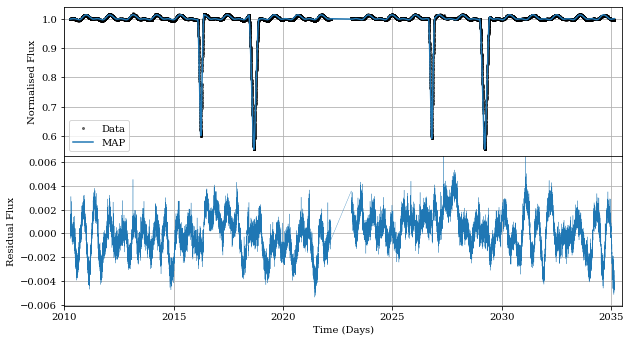

In [8]:
plt.rcParams['font.family'] = 'Serif'
fig, (ax, ax2) = plt.subplots(2, figsize=(10, 5.5), sharex=True)
fig.subplots_adjust(hspace=0)


ax.plot(time, flux, "k.", alpha=0.5, ms=4, label="Data")
ax.plot(time, flux_model, "C0", label="MAP")
ax2.plot(time, flux-flux_model, "C0", label="Residual", lw=0.3)

ax.set_ylabel('Normalised Flux'); ax2.set_ylabel('Residual Flux'); ax2.set_xlabel("Time (Days)")
ax.legend(); ax.grid(); ax2.grid()
ax.set_xlim(2010, 2035.5); ax2.set_ylim(ymax=0.0065)
# fig.savefig('Flux Model (ydeg=4, mcmc MAP).png', dpi=400, bbox_inches='tight')
# fig.savefig('Flux Model (ydeg=4, mcmc MAP).pdf', dpi=400, bbox_inches='tight')

2016.2421204866569


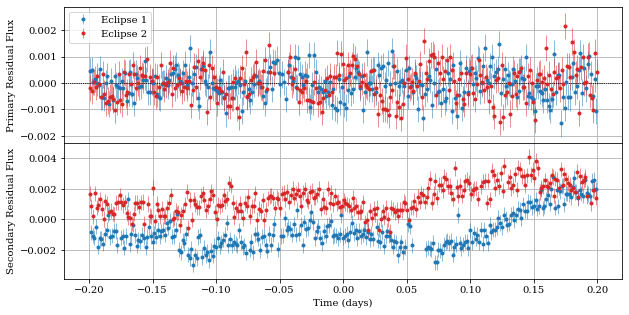

In [9]:
resflux = flux-flux_model
MidPrimary1 = map_soln["t0"]; MidPrimary2 = map_soln["t0"] + orb_period
primary1index = [i for i, t in enumerate(time) if (MidPrimary1 - 0.2) <= t <= (MidPrimary1 + 0.2)]
primary2index = [i for i, t in enumerate(time) if (MidPrimary2 - 0.2) <= t <= (MidPrimary2 + 0.2)]

sec_t0 = 0; sec_t0Flux = 1
for i, t in enumerate(time):
    if 2015 <= t <= 2018:
        if flux[i] < sec_t0Flux:
            sec_t0Flux = flux[i]; sec_t0 = t
MidSecondary1 = sec_t0; MidSecondary2 = sec_t0 + orb_period
secondary1index = [i for i, t in enumerate(time) if (MidSecondary1 - 0.2) <= t <= (MidSecondary1 + 0.2)]
secondary2index = [i for i, t in enumerate(time) if (MidSecondary2 - 0.2) <= t <= (MidSecondary2 + 0.2)]

print(sec_t0)

fig, (ax, ax2) = plt.subplots(2, figsize=(10, 5), sharex=True)
fig.subplots_adjust(hspace=0)
# set the error in flux to 5e-4, as thats slightly biggest than the biggest error in the data (ran into trouble using actual err vals)
ax.errorbar(time[primary1index] - MidPrimary1, resflux[primary1index], yerr=5e-4, fmt='.', color='tab:blue', label='Eclipse 1', lw=0.5)
ax.errorbar(time[primary2index] - MidPrimary2, resflux[primary2index], yerr=5e-4, fmt='.', color='tab:red', label='Eclipse 2', lw=0.5)

ax2.errorbar(time[secondary1index] - MidSecondary1, resflux[secondary1index], yerr=5e-4, fmt='.', color='tab:blue', lw=0.5)
ax2.errorbar(time[secondary2index] - MidSecondary2, resflux[secondary2index], yerr=5e-4, fmt='.', color='tab:red', lw=0.5)

ax.axhline(0, c='k', lw=0.7, ls=':'); ax.axhline(0, c='k', lw=0.7, ls=':')

ax.set_ylabel("Primary Residual Flux")
ax2.set_xlabel("Time (days)")
ax2.set_ylabel("Secondary Residual Flux")

ax.legend(loc="upper left")
ax.grid(); ax2.grid()
# fig.savefig('Residual Eclipse Zoom (ydeg=4, mcmc MAP).png', dpi=400, bbox_inches='tight')
# fig.savefig('Residual Eclipse Zoom (ydeg=4, mcmc MAP).pdf', dpi=400, bbox_inches='tight')


In [10]:
from astropy.timeseries import LombScargle

res_flux = flux - flux_model
days = np.linspace(0.01, 30, 10000)
freqs = 1 / days
LS = LombScargle(time, res_flux) # initialize a Lomb-Scargle
power = LS.power(freqs) # calculate LS power 

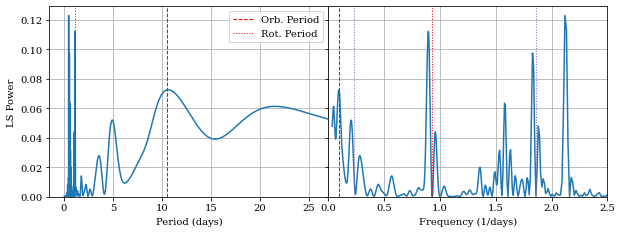

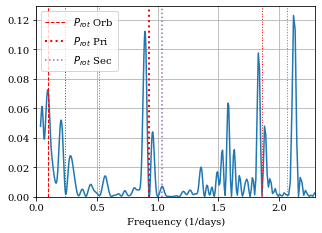

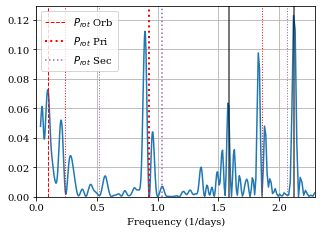

In [11]:
freqMax = 0
maxPower = 0
for i, f in enumerate(freqs):
    if f > 1:
        if power[i] >= maxPower:
            freqMax = f
            maxPower = power[i]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
fig.subplots_adjust(wspace=0)

ax1.plot(1 / freqs, power)
ax1.set_xlabel('Period (days)')
ax1.set_ylabel('LS Power')
ax1.axvline(orb_period, c='r', ls='--', lw=1, label=f"Orb. Period")# ({map_soln['period']:.2f} days)")
ax1.axvline(map_soln['A_prot'], c='r', ls=':', lw=1, label=f"Rot. Period")# ({map_soln['A_prot']:.2f} days)")
ax1.set_ylim(ymin=0); ax1.set_xlim(xmax=27)
ax1.legend()

ax2.plot(freqs, power)
ax2.set_xlabel('Frequency (1/days)')
ax2.set_xlim(0, 2.5)
ax2.axvline(1 / orb_period, c='r', ls='--', lw=1, label=f"Orb. Period")# ({map_soln['period']:.2f} days)")
ax2.axvline(1 / map_soln['A_prot'], c='r', ls=':', lw=1, label=f"Rot. Period")# ({map_soln['A_prot']:.2f} days)")
ax2.axvline(2 / (map_soln['A_prot']), c='tab:purple', ls=':', lw=1, label=f"Rot. Period")
ax2.axvline(1 / (4 * map_soln['A_prot']), c='tab:purple', ls=':', lw=1, label=f"Rot. Period")

ax1.grid(); ax2.grid()

# fig.savefig('Residuals Lomb-Scargle (ydeg=4, mcmc MAP).png', dpi=400, bbox_inches='tight')
# fig.savefig('Residuals Lomb-Scargle (ydeg=4, mcmc MAP).pdf', dpi=400, bbox_inches='tight')

for i in range(2):
    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.plot(freqs, power)
    ax.set_xlabel('Frequency (1/days)')
    ax.set_xlim(0, 2.3)
    for mult in [1]:
        lab = "$P_{rot}$ Orb" if mult == 1 else None; lw = 1 if mult == 1 else 1
        ax.axvline(1 / (mult * orb_period), c='r', ls='--', lw=lw, label=lab)# ({map_soln['period']:.2f} days)")
    for mult in [0.5, 1, 4]:
        lab = "$P_{rot}$ Pri" if mult == 1 else None; lw = 2 if mult == 1 else 1
        ax.axvline(1 / (mult * map_soln['A_prot']), c='r', ls=':', lw=lw, label=lab)# ({map_soln['A_prot']:.2f} days)")
    for mult in [0.5, 1, 2]:
        lab = "$P_{rot}$ Sec" if mult == 1 else None; lw = 1.5 if mult == 1 else 1
        ax.axvline(1/(mult * 0.97), c='tab:purple', ls=':', lw=lw, label=lab)
    ax.grid(); ax.legend(loc='upper left')
    ax.set_ylim(ymin=0);
    if i == 1:
        ax.axvline(freqMax, c='k', alpha=0.7); ax.axvline(0.75 * freqMax, c='k', alpha=0.7)
#         fig.savefig('Residuals Lomb-Scargle FREQ3-4(ydeg=4, mcmc MAP).png', dpi=400, bbox_inches='tight')
#         fig.savefig('Residuals Lomb-Scargle FREQ3-4(ydeg=4, mcmc MAP).pdf', dpi=400, bbox_inches='tight')
    else:
#         fig.savefig('Residuals Lomb-Scargle FREQ(ydeg=4, mcmc MAP).png', dpi=400, bbox_inches='tight')
#         fig.savefig('Residuals Lomb-Scargle FREQ(ydeg=4, mcmc MAP).pdf', dpi=400, bbox_inches='tight')
        continue

    

In [12]:
import matplotlib
map = starry.Map(udeg=2,ydeg=4)
map.inc = map_soln["A inc deg"]
map.amp = x[0]
map[1:, :] = x[1 : primary.map.Ny] / map.amp
map[1] = map_soln['u1']
map[2] = map_soln['u2']
map.show(theta=np.linspace(0, 360, 50))
# map.show(theta=np.linspace(0, 360, 50), file='MAPPrimaryAnimation.mp4')
# map.show(theta=np.linspace(0, 360, 50), file='MAPPrimaryAnimation.gif')
print(x[0])


map2 = starry.Map(udeg=2,ydeg=1)
map2.inc = 90
map2[1] = map_soln['u1']
map2[2] = map_soln['u2']
map2.amp = x[primary.map.Ny]
map2[1:, :] = x[primary.map.Ny + 1 :] / map2.amp
map2.show(theta=np.linspace(0, 360, 50))
# map2.show(theta=np.linspace(0, 360, 50), file='MAPSecondaryAnimation.mp4')
# map2.show(theta=np.linspace(0, 360, 50), file='MAPSecondaryAnimation.gif')

0.45485138045905776


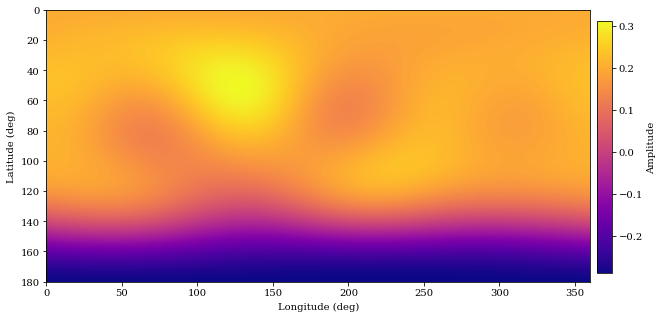

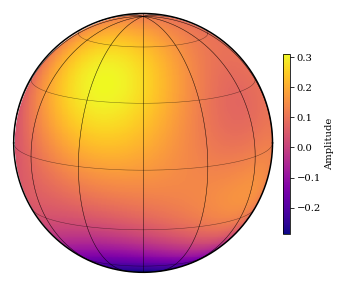

In [13]:
surfMap = map.render(projection="rect").eval()

fig, ax = plt.subplots(figsize=(10, 5))

img = ax.imshow(surfMap, cmap="plasma", extent=(0, 360, 0, 180))
ax.invert_yaxis()
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])

ax.set_ylabel("Latitude (deg)")
ax.set_xlabel("Longitude (deg)")

cbar = fig.colorbar(img, cax=cbar_ax)
cbar.set_label("Amplitude")
# fig.savefig('Surface Map (ydeg=4, mcmc MAP).png', dpi=400, bbox_inches='tight')
# fig.savefig('Surface Map (ydeg=4, mcmc MAP).pdf', dpi=400, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5, 5))
map.show(ax = ax, theta=30)

cbar_ax = fig.add_axes([0.9, 0.25, 0.02, 0.5])
cbar = fig.colorbar(img, cax=cbar_ax)
cbar.set_label("Amplitude")
# fig.savefig('Sphere Map (ydeg=4, mcmc MAP).png', dpi=400, bbox_inches='tight')
# fig.savefig('Sphere Map (ydeg=4, mcmc MAP).pdf', dpi=400, bbox_inches='tight')